# <div align = 'center'> <font color='red'> BOLUM 8
#  <div align = 'center'> <font color='red'>                           XGBOOSTING

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/LifeExpectancy.csv', index_col=0)

In [4]:
df2 = pd.read_csv('data/Wine.csv')
df2.type =  df2.type.map({'white':0, 'red':1} )

In [5]:
df2.head(1)

,Unnamed: 0,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_range
0,0,0,7.0,0.27,0.36,17.2,0.045,45.0,170.0,1.001,3.0,0.45,8.8,1


## 1. XGBoost ile Sınıflandırma (xgb.DMatrix)

In [6]:
X = df.drop('Life_Expectancy', axis=1)
y = df.Life_Expectancy

In [7]:
X = df2.drop('quality_range', axis=1)
y = df2.quality_range


In [8]:
#Lifed_matrix = xgb.DMatrix(data = X, label=y)

In [9]:
wine_dmatrix = xgb.DMatrix(data = X, label=y)

Modelimizi oluşturuken kullancağımız parametreleri belirliyoruz. XGBoost parametreleri içinde en önemlilerinden bir tanesi objective paramatresidir. Bu parametre ile modelimizin hata fonksiyonu olarak ne kullanacağını belirtiyoruz.

Regresyon problemlerinde reg:linear
Sınıflandırma modellerinde ise, tahmin edilen sınıf için reg-logistic, tahmin ihtimali için ise binary:logistic ifadesi kullanılır.

In [10]:
print("Dataset has {} entries and {} features".format(*df2.shape))

Dataset has 6497 entries and 14 features


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [12]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

**Building a baseline model**
We are going to use mean absolute error (MAE) to evaluate the quality of our predictions. MAE is a common and simple metric that has the advantage of being in the same unit as our target, which means it can be compared to target values and easily interpreted. You can compute MAE by summing the absolute errors between your predictions and the true values of the target and averaging over all observations.

In [13]:
from sklearn.metrics import mean_absolute_error

In order to get an idea of the range of MAE we would like to achieve here, we are going to build a baseline model, and save its score for later. This score is what we can achieve with no efforts, so we hope we will beat it with our fancy algorithm.
For our baseline, we will keep things simple and predict that each new post will get the mean number of comments that we observed in the training set.

In [14]:
# "Learn" the mean from the training data
mean_train = np.mean(y_train)

# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train

# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))


Baseline MAE is 0.46


In [15]:
mean_train

0.6324802770829324

In [16]:
baseline_predictions

array([0.63248028, 0.63248028, 0.63248028, ..., 0.63248028, 0.63248028,
       0.63248028])

That is, the prediction is, on average, 0.46 quality range off from the actual number of quality of wine. Is that good???

In [18]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [19]:
params['eval_metric'] = "mae"

In [20]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=250,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))


[22:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.458361
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.427509
[2]	Test-mae:0.405352
[3]	Test-mae:0.38941
[4]	Test-mae:0.378444
[5]	Test-mae:0.369081
[6]	Test-mae:0.363264
[7]	Test-mae:0.357332
[8]	Test-mae:0.352268
[9]	Test-mae:0.349638
[10]	Test-mae:0.345965
[11]	Test-mae:0.342897
[12]	Test-mae:0.33922
[13]	Test-mae:0.337962
[14]	Test-mae:0.335848
[15]	Test-mae:0.333772
[16]	Test-mae:0.331114
[17]	Test-mae:0.330889
[18]	Test-mae:0.328519
[19]	Test-mae:0.32704
[20]	Test-mae:0.326529
[21]	Test-mae:0.325878
[22]	Test-mae:0.325363
[23]	Test-mae:0.324446
[24]	Test-mae:0.323611
[25]	Test-mae:0.321857
[26]	Test-mae:0.32159
[27]	Test-mae:0.321062
[28]	Test-mae:0.320858
[29]	Test-mae:0.318966
[30]	Test-mae:0.319306
[31]	Test-mae:0.319247
[32]	Test-mae:0.318742
[33]	Test-mae:0.318839
[34]	Test-ma

134e kadar geldi sadece 250 yerine Gerek kalmadi.

In [21]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=250,
    seed=40,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results.sort_values(by='test-mae-mean', ascending=True).head(20)

[22:44:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
152,0.223601,0.000992,0.302511,0.006402
151,0.223961,0.000830,0.302562,0.006376
150,0.224430,0.000764,0.302734,0.006335
149,0.224995,0.000850,0.303029,0.006383
148,0.225355,0.000823,0.303042,0.006406
147,0.225752,0.000679,0.303256,0.006348
145,0.226557,0.000695,0.303400,0.006345
146,0.226131,0.000652,0.303464,0.006371
144,0.227097,0.000695,0.303640,0.006351
142,0.227811,0.000746,0.303703,0.006405


In [22]:
#cv returns a table where the rows correspond to the number of boosting trees used 
#The 4 columns correspond to the mean and standard deviation of MAE on the test dataset and on the train dataset. 
#For now I will only try to improve the mean test MAE. We can get the best MAE score from cv with:

cv_results['test-mae-mean'].min()

0.3025112

**Parameters max_depth and min_child_weight
Those parameters add constraints on the architecture of the trees.**
* **max_depth** is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.

* **min_child_weight** is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

Thus, those parameters can be used to control the complexity of the trees. It is important to tune them together in order to find a good trade-off between model bias and variance

In [25]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,9)
    for min_child_weight in range(1,5)
]

In [26]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=250,
        seed=40,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=6, min_child_weight=1
[22:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2617076 for 249 rounds
CV with max_depth=6, min_child_weight=2
[22:46:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/sr

	MAE 0.24937399999999998 for 249 rounds
CV with max_depth=8, min_child_weight=3
[22:47:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.25490859999999993 for 249 rounds
CV with max_depth=8, min_child_weight=4
[22:47:46] WARNING: 

In [27]:
params['max_depth'] = 8
params['min_child_weight'] = 2

**Parameters subsample and colsample_bytree**
Those parameters control the sampling of the dataset that is done at each boosting round.
Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

* subsample corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
* colsample_bytree corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.
Let’s see if we can get better results by tuning those parameters together.

In [28]:
# Let’s see if we can get better results by tuning those parameters together.
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/9. for i in range(3,9)]
    for colsample in [i/9. for i in range(3,9)]]

In [29]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=250,
        seed=40,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=0.8888888888888888, colsample=0.8888888888888888
[22:49:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.25424579999999997 for 249 rounds
CV with subsample=0.8888888888888888, colsample=0.7777777777777778
[22:49

	MAE 0.263094 for 249 rounds
CV with subsample=0.7777777777777778, colsample=0.5555555555555556
[22:50:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2667052 for 249 rounds
CV with subsample=0.7777777777777778, colsample=0.4444

	MAE 0.2773366 for 249 rounds
CV with subsample=0.5555555555555556, colsample=0.8888888888888888
[22:51:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2731842 for 249 rounds
CV with subsample=0.5555555555555556, colsample=0.777

	MAE 0.2859498 for 249 rounds
CV with subsample=0.4444444444444444, colsample=0.5555555555555556
[22:52:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.28574780000000005 for 249 rounds
CV with subsample=0.4444444444444444, colsa

	MAE 0.30677519999999997 for 247 rounds
Best params: 0.8888888888888888, 0.7777777777777778, MAE: 0.25384


**It looks like we start converging and our MAE is not getting much better.**

**Aslinda bir onceki modelde 'max_depth' = 8 ve 'min_child_weight' = 2 parametreleri ile MAE: 0.24937399999999998 idi simdi 
**'subsample'=0.88 ve colsample_bytree 0.77 iken MAE: 0.25384 oldu.**

**Normalde burdan sonra degistirmem gerekmez ama ornekte bulunsun diye yapiyorum.**

In [30]:
# Again, updating params dictionary.
params['subsample'] = .88
params['colsample_bytree'] = .77

In [32]:
params
{'colsample_bytree': 0.77,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 8,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'subsample': 0.8}

{'colsample_bytree': 0.77,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 8,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'subsample': 0.8}

Trainign the last model again 

In [34]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=250,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[22:59:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.448619
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.403236
[2]	Test-mae:0.376221
[3]	Test-mae:0.354251
[4]	Test-mae:0.333457
[5]	Test-mae:0.31753
[6]	Test-mae:0.306265
[7]	Test-mae:0.300005
[8]	Test-mae:0.294824
[9]	Test-mae:0.292285
[10]	Test-mae:0.288963
[11]	Test-mae:0.287934
[12]	Test-mae:0.284117
[13]	Test-mae:0.280248
[14]	Test-mae:0.276877
[15]	Test-mae:0.276029
[16]	Test-mae:0.274355
[17]	Test-mae:0.27315
[18]	Test-mae:0.272739
[19]	Test-mae:0.271335
[20]	Test-mae:0.270743
[21]	Test-mae:0.269882
[22]	Test-mae:0.268904
[23]	Test-mae:0.267853
[24]	Test-mae:0.267461
[25]	Test-mae:0.266605
[26]	Test-mae:0.265153
[27]	Test-mae:0.263877
[28]	Test-mae:0.263484
[29]	Test-mae:0.261448
[30]	Test-mae:0.261283
[31]	Test-mae:0.259587
[32]	Test-mae:0.259477
[33]	Test-mae:0.258926
[34]	Test-

improved MAE little more. 

<div align = 'center'>**Saving our model**
    
Although we found the best number of rounds, our model has been trained with more rounds than optimal, thus before using it for predictions, we should retrain it with the good number of rounds. Since we now the exact best num_boost_round, we don't need the early_stopping_round anymore.

In [35]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=250,
    evals=[(dtest, "Test")]
)

[23:00:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.448619
[1]	Test-mae:0.403236
[2]	Test-mae:0.376221
[3]	Test-mae:0.354251
[4]	Test-mae:0.333457
[5]	Test-mae:0.31753
[6]	Test-mae:0.306265
[7]	Test-mae:0.300005
[8]	Test-mae:0.294824
[9]	Test-mae:0.292285
[10]	Test-mae:0.288963
[11]	Test-mae:0.287934
[12]	Test-mae:0.284117
[13]	Test-mae:0.280248
[14]	Test-mae:0.276877
[15]	Test-mae:0.276029
[16]	Test-mae:0.274355
[17]	Test-mae:0.27315
[18]	Test-mae:0.272739
[19]	Test-mae:0.271335
[20]	Test-mae:0.270743
[21]	Test-mae:0.269882
[22]	Test-mae:0.268904
[23]	Test-mae:0.267853
[24]	Test-mae:0.267461
[25]	Test-mae:0.266605
[26]	Test-mae:0.265153
[27]	Test-mae:0.263877
[28]	Test-mae:0.263484
[29]	Test-mae:0.261448
[30]	Test-mae:0.261283
[31]	Test-mae:0.259587
[32]	Test-mae:0.259477
[33]	Test-mae:0.258926
[34]	Test-mae:0.258417
[35]	Test-mae:0.256973
[36]	Test-mae:0.2563

In [36]:
mean_absolute_error(best_model.predict(dtest), y_test)

0.22947114183100403

MAE en dusuk degerine geldi. 

In [37]:
best_model.save_model("my_model.model")

**You can then load the model later with:**  
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")

* And use it for predictions.
loaded_model.predict(dtest)

# Ders Notlarindan Yeniden Islemler

In [38]:
X = df2.drop('quality_range', axis=1)
y = df2.quality_range

In [39]:
params = {"objective":"reg:logistic", "max_depth":3, "silent":1}

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

wine_dmatrix = xgb.DMatrix(data = X, label=y)

In [41]:
df2_cv = xgb.cv(dtrain=wine_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics="error", as_pandas=True, seed=123)
display(df2_cv)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.262660,0.003347,0.271357,0.003454
1,0.256349,0.003424,0.266432,0.006400
2,0.251809,0.004661,0.263199,0.004990
3,0.250501,0.003417,0.264893,0.007354
4,0.244498,0.002306,0.261507,0.007842


xgb.cv fonksiyonunda değerlendirme metriği olarak hata oranı ("error") tanımladık. as_pandas parametresini True olarak belirttiğimiz için sonuç olarak test ve eğitim verileri için hata oranını ve hata oranının standart sapmasını veri çerçevesi olarak döndürdü. Hata değerini 1'den çıkararak doğruluk (accuracy) değerini bulabiliriz.

In [42]:
print('Doğruluk Değeri : {:.3f}'.format((1-df2_cv["test-error-mean"]).max()))

Doğruluk Değeri : 0.738


Modelimiz 5 iterasyon sonunda en 0.738 gibi bir duğruluk değerine ulaştı.

Modelimizin performansını AUC skoru ile de değerlendirebiliriz.

In [43]:
wine_auc = xgb.cv(dtrain=wine_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics="auc", as_pandas=True, seed=123)
display(wine_auc)
print('AUC Skoru : {:.3f}'.format(wine_auc["test-auc-mean"].max()))


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.786421,0.004296,0.768510,0.005279
1,0.803147,0.001637,0.787364,0.005780
2,0.812467,0.002649,0.796505,0.002184
3,0.817142,0.002379,0.800257,0.000868
4,0.822573,0.000661,0.802156,0.003129


AUC Skoru : 0.802


## 2. XGBoost ile Regresyon (XGBRegressor)

In [44]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


df.head()

,Year,Life_Expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under_five_deaths,Polio,Total_Expenditure,Diphtheria,HIV/AIDS,GDP,thinness_1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling
0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,16.6,6.9,0.479,10.1
1,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,16.6,6.9,0.476,10.0
2,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,16.6,6.9,0.470,9.9
3,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,16.6,6.9,0.463,9.8
4,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,16.6,6.9,0.454,9.5


In [45]:
X = df.drop('Life_Expectancy', axis=1)
y = df.Life_Expectancy

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)


xg_reg = xgb.XGBRegressor(objective ='reg:linear', seed=40)


In [48]:
params_reg = {'colsample_bytree': [0.3, 0.7], 
                       'gamma': [0.001, 0.1], 
                       'learning_rate': [0.3], 
                       'max_depth': [3], 
                       'min_child_weight': [3], 
                       'n_estimators': [50],
                       'silent':[1]
                      }

In [49]:
from sklearn.model_selection import GridSearchCV


grid_cv = GridSearchCV(estimator=xg_reg,
                       param_grid = params_reg,
                       cv = 10
                      )
grid_cv.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=40, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'colsample_bytree': [0.3, 0.7], 'gamma': [0.001, 0.1], 'learning_rate': [0.3], 'max_depth': [3], 'min_child_weight': [3], 'n_estimators': [50], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
print("En iyi parametreler : ", grid_cv.best_params_)
print("En iyi skor         : ", grid_cv.best_score_)

En iyi parametreler :  {'colsample_bytree': 0.7, 'gamma': 0.001, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'silent': 1}
En iyi skor         :  0.90793937130995


In [51]:
grid_cv.fit(X_train,y_train)

y_pred = grid_cv.predict(X_test)

rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_reg))

RMSE: 2.404753


XGBoost varsayılan değer olarak zayıf öğrenici olarak karar ağaçlarını kullandığı için booster="gbtree" varsayılan olarak belirlenmiştir. XGBoost'ta çok kullanılmasa da karar ağacı yerine lineer model kullanmak istersek booster:"gblinear" şeklinde belirtebiliriz. Bu yöntem çok yaygın olmadığından bu yöntem sklearn API ile kullanılamamakta. Bu yüzden bunun için yine DMatrix veri yapısını kullanmamız gerekecek

In [52]:
DM_train = xgb.DMatrix(data = X_train, label=y_train)
DM_test =  xgb.DMatrix(data = X_test, label=y_test)

In [53]:
params = {"booster":"gblinear", "objective":"reg:linear"}
xg_reg = xgb.train(dtrain=DM_train, params=params, num_boost_round=5)

#Modelimizi eğittik. Şimdi performansına bakalım.

[23:03:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [54]:
y_pred_gblinear = xg_reg.predict(DM_test)
rmse_gblinear = np.sqrt(mean_squared_error(y_test, y_pred_gblinear))
print("RMSE: %f" % (rmse_gblinear))

RMSE: 5.807476


İki modelin Kök Ortalama Kare Hataların (RMSE) karşılaştırdığımızda karar ağaçlarını zayıf öğrenme algoritması olarak kullanan modelin çok daha iyi olduğunu görüyoruz.

In [55]:
rmse_gblinear

5.807475947175275

In [56]:
rmse_reg

2.4047526670102557

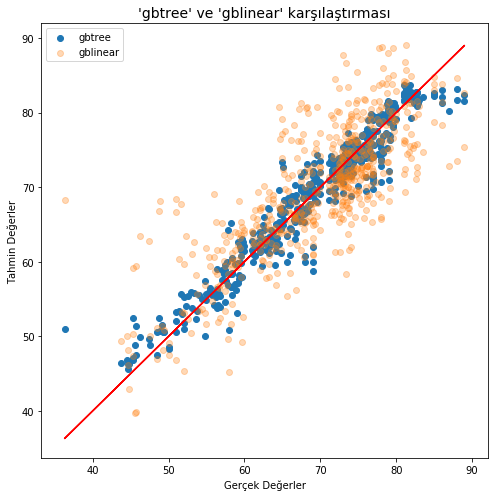

In [57]:
plt.figure(figsize=(8,8))
plt.title("'gbtree' ve 'gblinear' karşılaştırması", size = 14)
ax1 = plt.scatter(y_test, y_pred)
ax2 = plt.scatter(y_test, y_pred_gblinear, alpha=0.30)
ax3 = plt.plot(y_test, y_test, color="red")
plt.legend((ax1, ax2), ('gbtree', 'gblinear'))
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerler")
plt.show()


## 3. XGBoost ile model performansını artırma

Temel olarak XGBoost ile nasıl regresyon ve sınıflandırma modelleri oluşturulacağını gördük. Artık modelimizin kalitesini artıracak yöntemlere bakabiliriz.

## 3.1. XGBoost ile Çapraz Doğrulama
Çapraz doğrulama için XGBoost'un içerisinde yer alan cv fonksiyonunu kullanabileceğimiz gibi sklearn içerisinde yer alan cross_val_score fonksiyonunu da kullanabiliriz.

Çapraz doğrulama ile Ortalama Mutlak Hata (MAE) ve Kök Ortalama Kare Hata (RMSE) değerlerine odaklanalım.

In [58]:
df2_cv = xgb.cv(dtrain=wine_dmatrix, params=params, nfold=3, 
                    num_boost_round=100, metrics="rmse", as_pandas=True, seed=123, early_stopping_rounds = 5)

display(df2_cv.sort_values(by='test-rmse-mean').head(10))

[23:03:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
99,0.429942,0.002344,0.430812,0.004979
98,0.430032,0.002345,0.430902,0.004981
97,0.430125,0.002347,0.430992,0.004984
96,0.430217,0.002348,0.431082,0.004986
95,0.430310,0.002350,0.431174,0.004989
94,0.430404,0.002352,0.431266,0.004991
93,0.430499,0.002353,0.431359,0.004993
92,0.430595,0.002355,0.431453,0.004996
91,0.430691,0.002357,0.431547,0.004998
90,0.430789,0.002358,0.431642,0.005000


RMSE değeri 99. iterasyonda 0.430812'ye indi.

#### metrics parametresini "mae" olarak değiştirerek modelin ortalama mutlak hata değerini öğrenebiliriz.


In [59]:
df2_cv = xgb.cv(dtrain=wine_dmatrix, params=params, nfold=3, 
                    num_boost_round=100, metrics="mae", as_pandas=True, seed=123, early_stopping_rounds = 5)

display(df2_cv.sort_values(by='test-mae-mean').head(10))

[23:03:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
99,0.378935,0.004048,0.379770,0.004606
98,0.379083,0.004051,0.379915,0.004602
97,0.379232,0.004055,0.380061,0.004597
96,0.379383,0.004059,0.380210,0.004593
95,0.379536,0.004062,0.380361,0.004588
94,0.379692,0.004066,0.380515,0.004584
93,0.379850,0.004069,0.380671,0.004580
92,0.380010,0.004073,0.380829,0.004576
91,0.380173,0.004076,0.380989,0.004571
90,0.380339,0.004079,0.381152,0.004566


## 3.2. XGBoost ile Regularizasyon

XBoost'da regularizasyon için çoğunlukla aşağıdaki parametreleri kullanmaktayız:

**gamma** : Ağaçların bölünmesi esnasında izin verilen maksimum kayıp azalması. Büyük değerler olduğu takdirde daha az dallanma olacaktır.

**alpha** : Daha önceki lineer modellerde de gördüğümüz dalların ağırlıklarının l1 regularizasyonu. Büyük değerler daha fazla regularizasyon anlamına gelmektedir. Bu durumda bir çok ağacın ağırlığı 0 olmaktadır.

**lambda**: Dalların ağırlıklarının l2 regularizasyonu. l1 regularizasyonuna göre daha yumuşaktır.
L1 regularizasyonuna bakalım. alpha değerleri için bir liste oluşturup bir döngü ile tüm değerleri deneyelim. Herbir alpha değeri için RMSE değerlerini bir listeye atalım. params sözlüğü içinde alpha değeri bulunmuyordu. Döngü içerisinde sırasıyla listedeki alpha değerlerini parametrelere ekleyip, çapraz doğrulama modelimizi eğiteceğiz.

In [60]:
l1_params = np.arange(0.01, 0.2, 0.01)

params = {"objective":"reg:linear","max_depth":3, "silent":1}

rmses_l1 = []
for alpha in l1_params:
    params["alpha"] = alpha
    cv_rmse = xgb.cv(dtrain=wine_dmatrix, params=params, nfold=4, num_boost_round=100, 
                             metrics="rmse", as_pandas=True, early_stopping_rounds=10, seed=123)
    rmses_l1.append(cv_rmse["test-rmse-mean"].tail(1).values[0])

In [61]:
print("En iyi l1 değerleri:")
en_iyi_degerler = pd.DataFrame(list(zip(l1_params, rmses_l1)), columns=["l1", "rmse"])
display(en_iyi_degerler.sort_values('rmse').head())

En iyi l1 değerleri:


,l1,rmse
0,0.01,0.388006
4,0.05,0.388311
15,0.16,0.388379
1,0.02,0.388426
5,0.06,0.388500


In [62]:
gamma_listesi = [0.1, 1, 10, 100]

params = {"objective":"reg:linear","max_depth":3, "silent":1}

rmses_l1 = []
for gamma in l1_params:
    params["gamma"] = gamma
    cv_rmse = xgb.cv(dtrain=wine_dmatrix, params=params, nfold=4, num_boost_round=100, 
                             metrics="rmse", as_pandas=True, early_stopping_rounds=10, seed=123)
    rmses_l1.append(cv_rmse["test-rmse-mean"].tail(1).values[0])

In [63]:
print("En iyi l1 değerleri:")
en_iyi_degerler = pd.DataFrame(list(zip(l1_params, rmses_l1)), columns=["l1", "rmse"])
display(en_iyi_degerler.sort_values('rmse').head())

En iyi l1 değerleri:


,l1,rmse
6,0.07,0.388549
2,0.03,0.388822
17,0.18,0.389137
8,0.09,0.389152
7,0.08,0.389275


## 3.3. Hiperparametre Ayarlama 


Bütün makine öğrenimi modellerinde olduğu gibi XGBoost'da da hiperparametre ayarlaması modelin performansını oldukça etkilemektedir. Hatta XGBoost'da diğer algoritmalara nazaran daha çok parametre bulunmaktadır. Modelin kullanacağı parametreleri bir sözlük içerisinde belirttiğimizi görmüştük. Modeli oluşturuken bu sözlüğe daha fazla değişken tanımlayarak parametre ayarlaması yapabiliriz.

Modelin boosting için kaç iterasyon yapacağını num_boost_round değişkeni ile belirleyebiliyoruz. Ancak early_stopping_rounds parametresi ile belirleyeceğimiz iterasyon sayısınca metriklerde gelişme olmazsa iterasyonları otomatik olarak durdurabiliriz.

Ayarlama yapabileceğimiz bazı parametreler şunlardır:

**learning_rate** : Modelin öğrenme oranı yani hatayı azaltma oranı. Küçük öğrenme oranları daha fazla iterasyon gerektirir.

**gamma, alpha, lambda** : Yukarıda bahsettiğimiz regülarizasyon parametreleri.

**max_depth** : Her bir ağaç için maksimum derinlik.

**subsample** : Modeldeki verilerin bir ağacın eğitimi için kullanılacak oranı. 0 ila 1 arasında bir değerdir. Büyük değerler overfittinge yol açabilir.

**colsample_bytree** : Her ağaç için kullanılacak değişken oranı. Bir regularizasyon sayılabilir. Büyük değerler fazla değişkenli modellerden dolayı overfittinge yol açabilir.

**min_child_weight** : Bir dalın minimum ağırlık değeri. Düşük değerler underfittinge yol açabilir.

Yukarıdaki örnekte regularizasyon yaparken yaptığımız gibi deneyeceğimiz parametreleri bir listeye ekleyip, bir döngü ile en başarılı parametreleri bulabiliriz. Ya da bunun yerine sklearn kütüphanesindeki GridSearchCV ve RandomSearchCV fonksiyonlarını da kullanabiliriz.

Modelimizin değişkenlerinin önem derecesini plot_importance fonksiyonu sayesinde grafik ahalinde kolaylıkla görebiliyoruz. Bunun için bir model oluşturup en önemli değerlere bakalım.

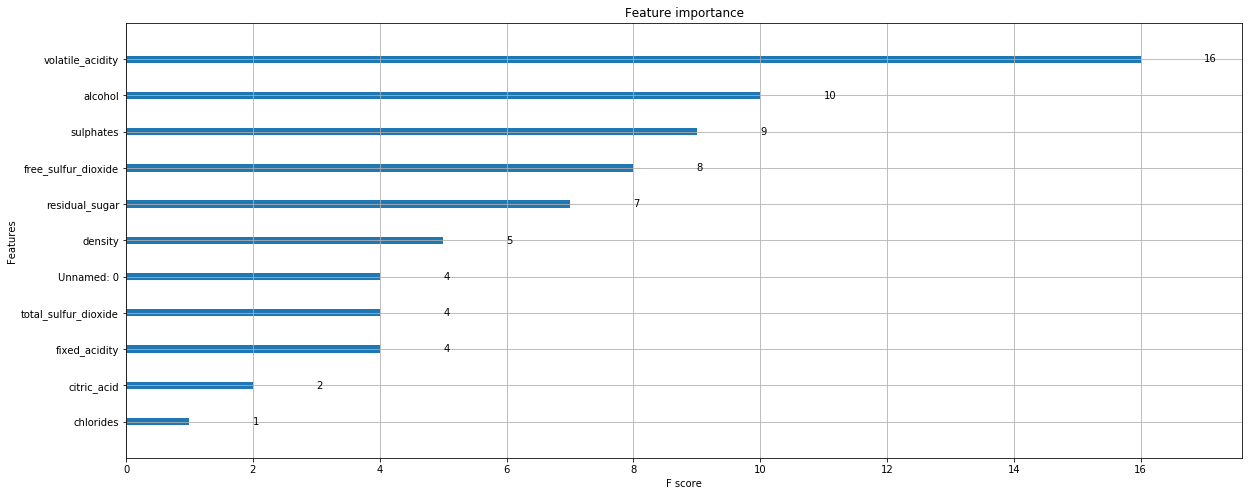

In [64]:

en_iyi_parametreler = {'objective':'reg:linear',
                       'colsample_bytree': 0.7, 
                       'gamma': 0.1, 
                       'learning_rate': 0.3, 
                       'max_depth': 3, 
                       'min_child_weight': 3, 
                       'n_estimators': 50,
                       'silent':1
                      }

wine_modeli = xgb.train(params=en_iyi_parametreler, dtrain=wine_dmatrix, num_boost_round=10)

ax = xgb.plot_importance(wine_modeli)
ax.figure.set_size_inches(20,8)
plt.show()

XGBoost'un görselleştirme olarak sunduğu araçlardan biri de plot_tree() fonksiyonudur. Bu fonksiyonu kullanarak ağaçları ve dalları görebiliriz.


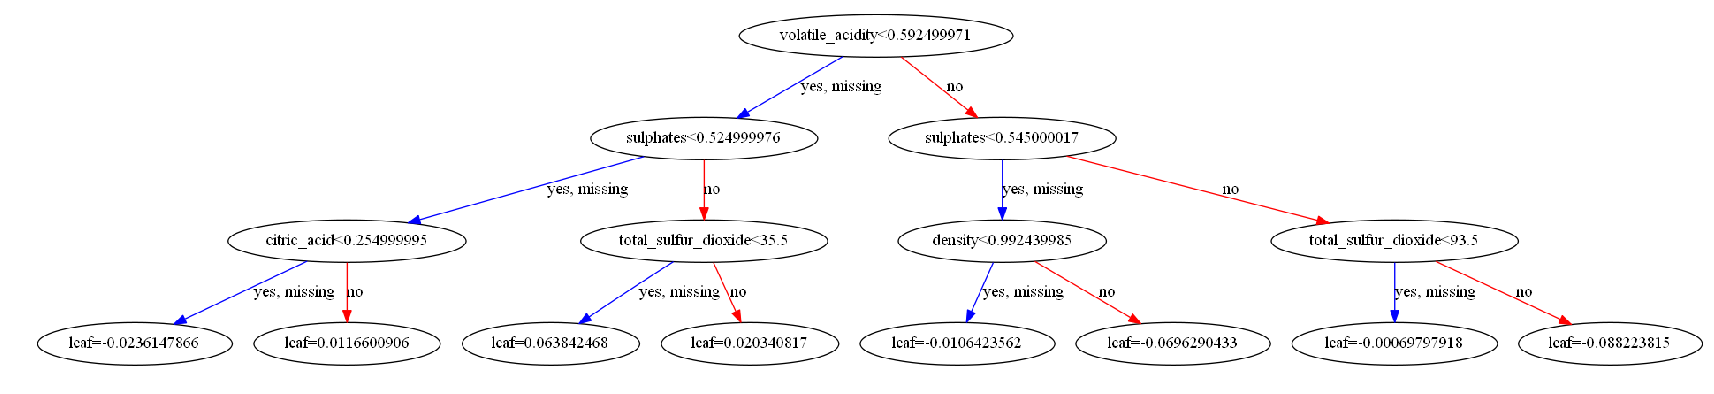

In [65]:
ax1 = xgb.plot_tree(wine_modeli, num_trees=4)
ax1.figure.set_size_inches(30,30)
plt.show()